### 简介

CausalML是一个Python包，它提供了一套基于最新研究的机器学习算法的uplift建模和因果推理方法。该软件包目前支持以下方法:


#### 基于树的算法:

- 基于KL散度、欧氏距离和卡方检验的uplift树/随机森林(KL divergence, Euclidean Distance, and Chi-Square)

- 基于上下文干预选择的的uplift树/随机森林（CTS,Contextual Treatment Selection）

#### Meta-learner算法:

- S-learner

- T-learner

- X-learner

- R-learner

在本笔记本中，我们使用合成数据来演示**基于树**的算法的使用。

In [4]:
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
from functools import reduce

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import UpliftTreeClassifier
from causalml.metrics import plot_gain
from sklearn.model_selection import train_test_split
import causalml
causalml.__version__


'0.12.3'

### 数据生成

CausalML库为uplift建模提供不同的合成数据函数，这里使用make_uplift_classification()生成了分类数据集


In [12]:
df, x_names = make_uplift_classification()
"""
df为合成数据
- 包含不同干预的组别treatment_group_key
- 19列/维特征数据，
- conversion为分类真值y值，表示是否转化
- treatment_effect表示干预之后是否转化

x_names
- 为19列数据对应列名
"""
print(df.shape)
print(df.treatment_group_key.unique())
# print(df.head(1))

# 每组别数据的转化率及样本量
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

(4000, 22)
['control' 'treatment3' 'treatment1' 'treatment2']


,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


### 使用公司营销数据

In [5]:
res= []
for i in range(5):
    df = pd.read_csv(f'data_{i}.csv')
    res.append(df)
combine = reduce(lambda x,y:pd.concat((x,y),axis=0),res)

### 使用uplift随机森林分类器

- 训练数据训练分类器
- 使用模型在测试数据预估
- 预测返回列包含每条数据的在对应干预或者对照下的预估uplift增益


In [6]:
# train test
df_train, df_test = train_test_split(combine, test_size=0.2, random_state=111)
print(df_train.shape,df_test.shape)

x_names = ['age','gender','age_span','register_span',
           'last_3d_mean_num','last_5d_mean_num','last_7d_mean_num',
           'last_10d_mean_num','last_14d_mean_num',
           'last_30d_mean_num','last_1d_num','last_2d_num','last_3d_num',
          'last_4d_num','last_5d_num','last_6d_num','last_7d_num','last_1w_same_day_num',
          'last_2w_same_day_num','last_3w_same_day_num','last_4w_same_day_num',
           
           'last_1w_buy_card_num','last_2w_buy_card_num','last_3w_buy_card_num','last_4w_buy_card_num',
          'last_2m_buy_card_num','last_3m_buy_card_num',
          'latest_buy_during_day','latest_buy_during_num','latest_buy_original_price','latest_buy_discount_price','latest_buy_discount_rate',
          'most_buy_during_day','most_buy_during_num','most_buy_original_price','most_buy_discount_price','most_buy_discount_rate',
          'mean_buy_during_day','mean_buy_during_num','mean_buy_original_price','mean_buy_discount_price','mean_buy_discount_rate'

          ]

# uplift随机森林模型
uplift_model = UpliftRandomForestClassifier(control_name='control') #对照组
uplift_model.fit(df_train[x_names].values, # 特征
                 treatment=df_train['treatment_group_key'].values, # 干预种类：control，t1,...,tn
                 y=df_train['is_buy'].values)    # 真值y，表示是否转化 

# full_output 全部输出
# 包含了数据在对照和多种干预下的转化率；以及推荐的干预方式；以及每种干预相比对照的增量转化率；以及最大的增量值
df_res = uplift_model.predict(df_test[x_names].values, full_output=True) 

print(df_res.shape)
df_res.head()

(806086, 70) (201522, 70)
(201522, 13)


,control,t1,t2,t3,t4,t5,recommended_treatment,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,max_delta
0,0.011320,0.449869,0.761225,0.718184,0.072702,0.082888,2,0.438549,0.749905,0.706864,0.061382,0.071568,0.749905
1,0.628842,0.015065,0.021253,0.103823,0.618169,0.552220,0,-0.613776,-0.607589,-0.525018,-0.010673,-0.076622,-0.010673
2,0.655945,0.010220,0.008151,0.057477,0.262926,0.689990,5,-0.645725,-0.647794,-0.598469,-0.393019,0.034045,0.034045
3,0.011320,0.408373,0.767029,0.726561,0.071063,0.084066,2,0.397053,0.755709,0.715241,0.059743,0.072746,0.755709
4,0.528397,0.037466,0.075863,0.350513,0.603572,0.391720,4,-0.490931,-0.452535,-0.177884,0.075175,-0.136678,0.075175


### 特征重要性

<AxesSubplot:>

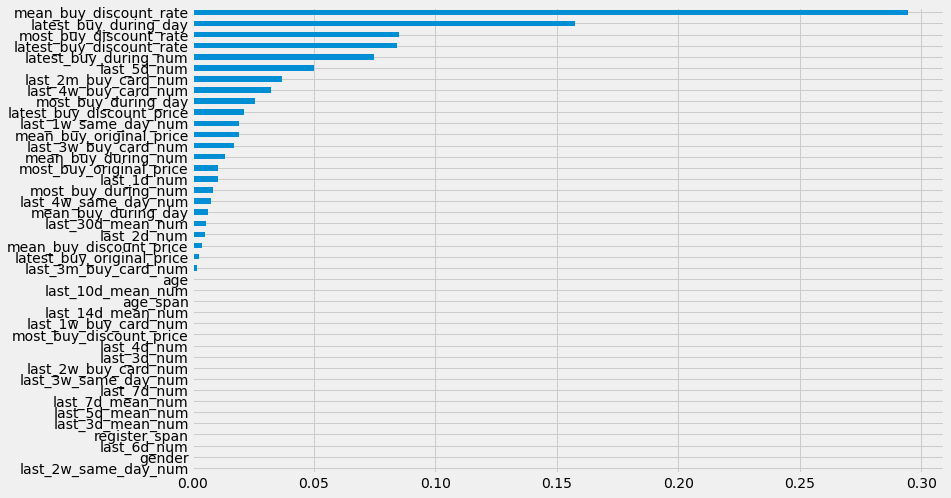

In [8]:
pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))


### 画uplifit曲线
- 因果推理和uplift建模综述：[http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf]
- 是综合总体考虑的评估方法，使用预测干预效果的分位数来计算实际干预效果
- 由于数据是随机的，我们在预测的分位数中有大致相等的干预和对照数

###  计算每个预测干预效果分位数的观察干预效果
- 我们利用观测到的干预效果来计算uplift曲线
- 这就回答了一个问题:如果我们根据预测的uplift从高到低对数据总体的子集进行排序，我们能捕捉多少的累积增益?
- 也就是每个数据按增益排序，就是下图x轴，y轴为对应增益值（数量级*100表示概率）

CausalML具有plot_gain()函数，该函数在给定的数据帧(DataFrame)中计算uplift曲线，该数据帧包含干预分配、观察结果和预测干预效果。

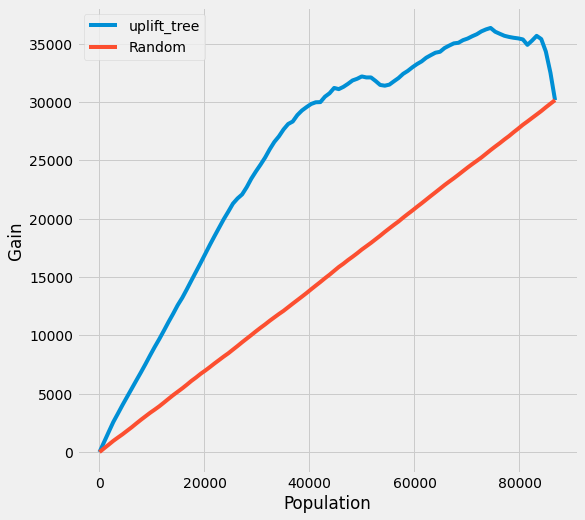

In [7]:
# 预测默认输出 三种干预 相对对照组不干预的增量转化率
y_pred = uplift_model.predict(df_test[x_names].values)  
y_pred

# 整洁表示
result = pd.DataFrame(y_pred,columns=uplift_model.classes_[1:])
result.head()
# 如果增量都为负那么最好的一个动作就分配为对照，否则就分配最大的增量对应的干预

best_treatment = np.where((result < 0).all(axis=1), 'control',  result.idxmax(axis=1)) #返回每行比较的最大值的列名，axis=1按行比较

# 创建指示变量，以确定一个单元是否恰好具有推荐的处理方法或是否属于对照组

actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0) # 是否推荐和实际干预处理/对照一致
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0) # 是否为对照数据
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]   # 相当于把我们预测对的以及对照组数据拿出来
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic], #该数据是否干预
                             conversion = df_test.loc[synthetic, 'is_buy'].values, #数据实际对应的转化情况
                             uplift_tree = synth.max(axis=1)) # 最高的增益数值
                     .drop(columns=list(uplift_model.classes_[1:])))

# auuc
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')